In [71]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycoingecko import CoinGeckoAPI

cg = CoinGeckoAPI()
pd.options.display.float_format = '{:.2f}'.format 

#el dataset lo obtuve originalmente usando la api de coingecko

#df = pd.DataFrame(cg.get_coins_markets(vs_currency='usd', per_page='50', price_change_percentage='1y', precision='4', sparkline='true'))
#df_cryptocurrencies=df
#df_cryptocurrencies.to_csv(r"C:\Users\\Administrator\\Desktop\\df_cryptocurrencies.csv")

df = pd.read_csv(r'dataset\df_cryptocurrencies.csv', dtype='unicode')

In [72]:
#testeo si funciona la conexion con la api
cg.ping()

{'gecko_says': '(V3) To the Moon!'}

In [73]:
df.head()

,Unnamed: 0,id,symbol,name,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,circulating_supply,...,max_supply,ath,ath_change_percentage,atl,atl_change_percentage,price_change_percentage_1y_in_currency,price_data,percentage_change,precio,cambio_en_%
0,0,bitcoin,btc,Bitcoin,26065.6349,506670672659.0,1,546620679270.0,6974223703.0,19465206.0,...,21000000.0,69045.0,-62.30113,67.81,38285.90763,21.87181178051062,"[29164.115145973017, 29191.82195842839, 29187....","[0.0, 0.09500309649956651, 0.07988818570284897...","[29164.115145973017, 29191.82195842839, 29187....","[0.0, 0.09500309649956651, 0.07988818570284897..."
1,1,ethereum,eth,Ethereum,1636.0522,196445974574.0,2,196445974574.0,9921574396.0,120211067.730788,...,0.0,4878.26,-66.51082,0.432979,377213.86215,0.8472599193034407,"[1826.9131281594616, 1827.2814071434173, 1827....","[0.0, 0.02015853837158963, 0.02942648060074059...","[1826.9131281594616, 1827.2814071434173, 1827....","[0.0, 0.02015853837158963, 0.02942648060074059..."
2,2,tether,usdt,Tether,0.9997,82748349121.0,3,82748349121.0,21264933560.0,82853331627.822,...,0.0,1.32,-24.51542,0.572521,74.44476,-0.10282539379700109,"[0.998364631059352, 0.9983897839406649, 0.9982...","[0.0, 0.002519408293360201, -0.007322793700341...","[0.998364631059352, 0.9983897839406649, 0.9982...","[0.0, 0.002519408293360201, -0.007322793700341..."
3,3,binancecoin,bnb,BNB,211.4062,32424800344.0,4,42149501784.0,753455286.0,153856150.0,...,200000000.0,686.31,-69.30611,0.0398177,528946.62917,-29.801793406617016,"[236.51214647820635, 236.38743839171167, 236.4...","[0.0, -0.05272798389074258, -0.034017483276096...","[236.51214647820635, 236.38743839171167, 236.4...","[0.0, -0.05272798389074258, -0.034017483276096..."
4,4,ripple,xrp,XRP,0.5204,27507358541.0,5,52055991487.0,1125599624.0,52841868447.0,...,100000000000.0,3.4,-84.68209,0.00268621,19279.43521,50.57126591188925,"[0.60937656314224, 0.6087412704642499, 0.60704...","[0.0, -0.10425288998878494, -0.382591459559019...","[0.60937656314224, 0.6087412704642499, 0.60704...","[0.0, -0.10425288998878494, -0.382591459559019..."


In [74]:
df.columns

Index(['Unnamed: 0', 'id', 'symbol', 'name', 'current_price', 'market_cap',
       'market_cap_rank', 'fully_diluted_valuation', 'total_volume',
       'circulating_supply', 'total_supply', 'max_supply', 'ath',
       'ath_change_percentage', 'atl', 'atl_change_percentage',
       'price_change_percentage_1y_in_currency', 'price_data',
       'percentage_change', 'precio', 'cambio_en_%'],
      dtype='object')

# Clasificación de las variables

### cuantitativos
* discretos = enteros
* continuos = se divide infinitamente

### cualitativos
* categoricos = de una categoria o clase especifica
* ordinales = de categoria en la que IMPORTA un orden o jerarquía

### Categoricas 

* id
* symbol
* name

### Discretas
* Ninguna

### Continuas  

* current_price 
* market_cap 
* fully_diluted_valuation --> si todas las monedas de una crypto estuvieran en circulacion, es para saber el potencial de una moneda con su valor actual
* total_volume 
* high_24h 
* low_24h
* circulating_supply
* total_supply
* max_supply
* ath
* ath_change_percentage
* atl
* atl_change_percentage
* ath_date
* atl_date
* roi
* price_change_24h
* price_change_percentage_24h
* market_cap_change_24h
* market_cap_change_percentage_24h
* sparkline_in_7d
* price_change_percentage_1y_in_currency

### Ordinales 

* market_cap_rank

## Conclusión

No hay variables discretas en mi opinion ya que si bien variables como circulating supply usualmente se refiere a una cantidad espcífica de monedas en circulación, cualquier moneda puede ser separada en partes más pequeñas de forma infinita, hence, es una variable continua.

La gran mayoría de variables son continuas ya que se trata de dinero o cryptos que, como ya dije, pueden dividirse infinitamente.

Cabe recalcar la importancia de la variable ordinal "market_cap_rank" ya que juega un papel muy importante en el mundo de las cryptos aquellas rankeadas en lo alto. Esto se debe a que ganan mayor fama y reconocimiento. Esta fama es incluso mayor si se trata de una crypto que logra mantenerse durante largos periodos de tiempo (años) en dicho ranking. Por ejemplo bitcoin, ethereum, usdt, etc.




In [75]:

try:
    #separo sparkline para usarla en un df por separado
    df_sparkline = df['sparkline_in_7d']

    #considero que no voy a utilizar estas columnas:
    df.drop(columns=['image','last_updated', 'roi', 'ath_date','atl_date',  'high_24h',
                    'low_24h','price_change_24h','price_change_percentage_24h','market_cap_change_24h',
                    'market_cap_change_percentage_24h', 'sparkline_in_7d'], inplace=True)
except:
    print("estas transformaciones ya se corrieron")

estas transformaciones ya se corrieron


In [76]:
df.describe()
#busco informacón relevante que me ayude a comenzar a filtrar ciertas criptomonedas

,Unnamed: 0,id,symbol,name,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,circulating_supply,...,max_supply,ath,ath_change_percentage,atl,atl_change_percentage,price_change_percentage_1y_in_currency,price_data,percentage_change,precio,cambio_en_%
count,50,50,50,50,50,50,50,50,50,50,...,50,50,50,50,50,46,50,50,50,50
unique,50,50,50,50,50,50,50,49,50,50,...,25,50,50,50,50,46,50,50,50,50
top,0,bitcoin,btc,Bitcoin,26065.6349,506670672659.0,1,0.0,6974223703.0,19465206.0,...,0.0,69045.0,-62.30113,67.81,38285.90763,21.87181178051062,"[29164.115145973017, 29191.82195842839, 29187....","[0.0, 0.09500309649956651, 0.07988818570284897...","[29164.115145973017, 29191.82195842839, 29187....","[0.0, 0.09500309649956651, 0.07988818570284897..."
freq,1,1,1,1,1,1,1,2,1,1,...,22,1,1,1,1,1,1,1,1,1


In [77]:
#hay valores nulos o perdidos
df.isna().sum()

Unnamed: 0                                0
id                                        0
symbol                                    0
name                                      0
current_price                             0
market_cap                                0
market_cap_rank                           0
fully_diluted_valuation                   0
total_volume                              0
circulating_supply                        0
total_supply                              0
max_supply                                0
ath                                       0
ath_change_percentage                     0
atl                                       0
atl_change_percentage                     0
price_change_percentage_1y_in_currency    4
price_data                                0
percentage_change                         0
precio                                    0
cambio_en_%                               0
dtype: int64

In [78]:
#no hay valores duplicados
df_dups = df.duplicated(subset=['id'])
dups = df[df.duplicated()]
dups



,Unnamed: 0,id,symbol,name,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,circulating_supply,...,max_supply,ath,ath_change_percentage,atl,atl_change_percentage,price_change_percentage_1y_in_currency,price_data,percentage_change,precio,cambio_en_%


In [79]:
#considero que para poder continuar, debo poner el tipo de dato que corresponde a cada columna

strings= ["id", "symbol", "name"]
floats=['current_price',
 'market_cap',
 'fully_diluted_valuation',
 'total_volume',
 'circulating_supply',
 'total_supply',
 'max_supply',
 'ath',
 'ath_change_percentage',
 'atl',
 'atl_change_percentage']

for i in strings:
    df[i].fillna(0)
    df[i] = df[i].astype("string")

for i in floats:
    df[i].replace('None', pd.NA, inplace=True)
    df[i].fillna(0, inplace=True)
    df[i] = df[i].astype("float")

df["market_cap_rank"] = df["market_cap_rank"].astype("int")

df.dtypes

Unnamed: 0                                        object
id                                        string[python]
symbol                                    string[python]
name                                      string[python]
current_price                                    float64
market_cap                                       float64
market_cap_rank                                    int32
fully_diluted_valuation                          float64
total_volume                                     float64
circulating_supply                               float64
total_supply                                     float64
max_supply                                       float64
ath                                              float64
ath_change_percentage                            float64
atl                                              float64
atl_change_percentage                            float64
price_change_percentage_1y_in_currency            object
price_data                     

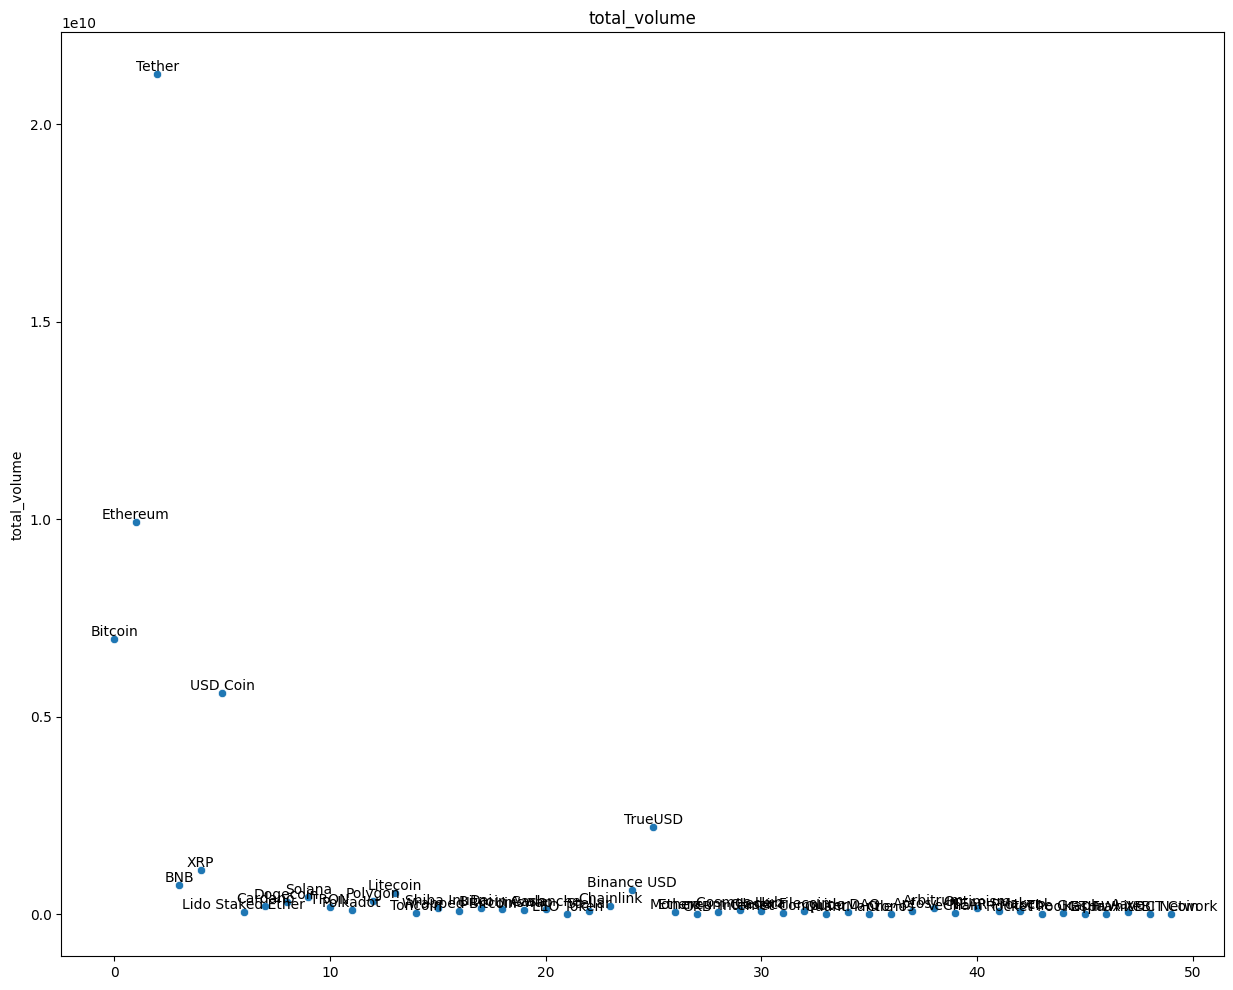

In [80]:
plt.figure(figsize=(15, 12))
sns.scatterplot(data=df['total_volume'])
plt.title("total_volume")

for index, row in df.iterrows():
    plt.text(index, row['total_volume'], row['name'], ha='center', va='bottom')

plt.show()

# Análisis

Este gráfico es interesante porque varían un poco los resultados en comparación a los demás donde bitcoin claramente es el único valor que llama la atención. 

En este gráfico se puede apreciar que USD Coin, Ethereum, Bitcoin y Tether son valores que sobresalen en comparación al resto. Esto se debe a que son de las criptomonedas más populares y con mayor adopción en los ultimos años. Es interesante ver como una stable coin como Tether tiene mayor volumen que Bitcoin. Esto se puede dar gracias a que Tether al ser una criptomoneda anclado al dolar, tiene un gran use case al ser usado en múltiples plataformas como método de pago al ser la stable coin más famosa de todas.

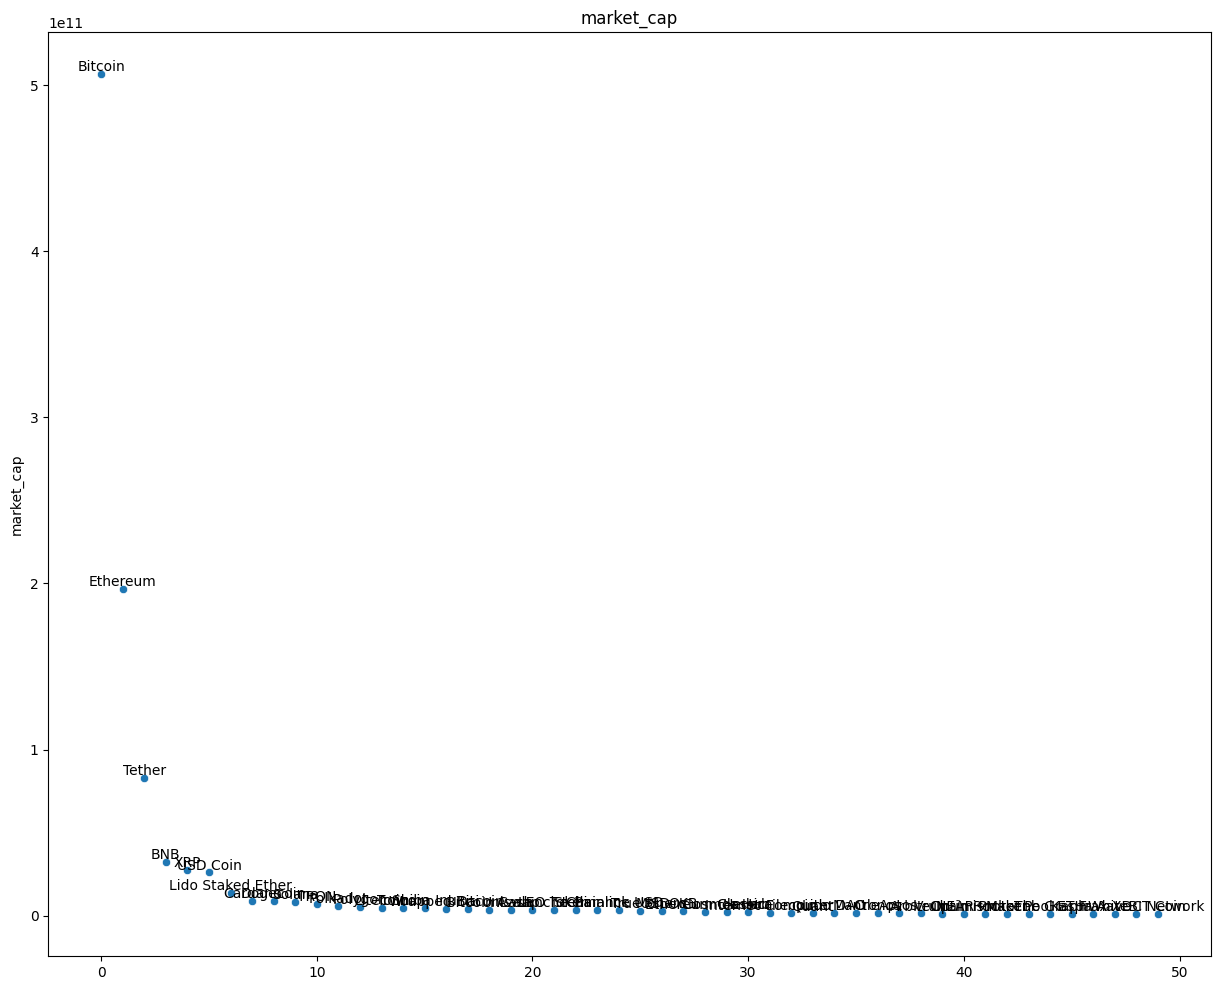

In [81]:
plt.figure(figsize=(15, 12))
sns.scatterplot(data=df['market_cap'])
plt.title("market_cap")

for index, row in df.iterrows():
    plt.text(index, row['market_cap'], row['name'], ha='center', va='bottom')

plt.show()

# Análisis
El mayor outlier que puedo ver es el de bitcoin pero eso se debe a que es la criptomoneda con mayor capitalización de mercado asi que es normal que sea un outlier. También se pueden observar los que le siguen en capitalizacion de mercado que serían Ethereu y Tether, ambas criptomonedas con mucha exposición en el mercado actual.

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


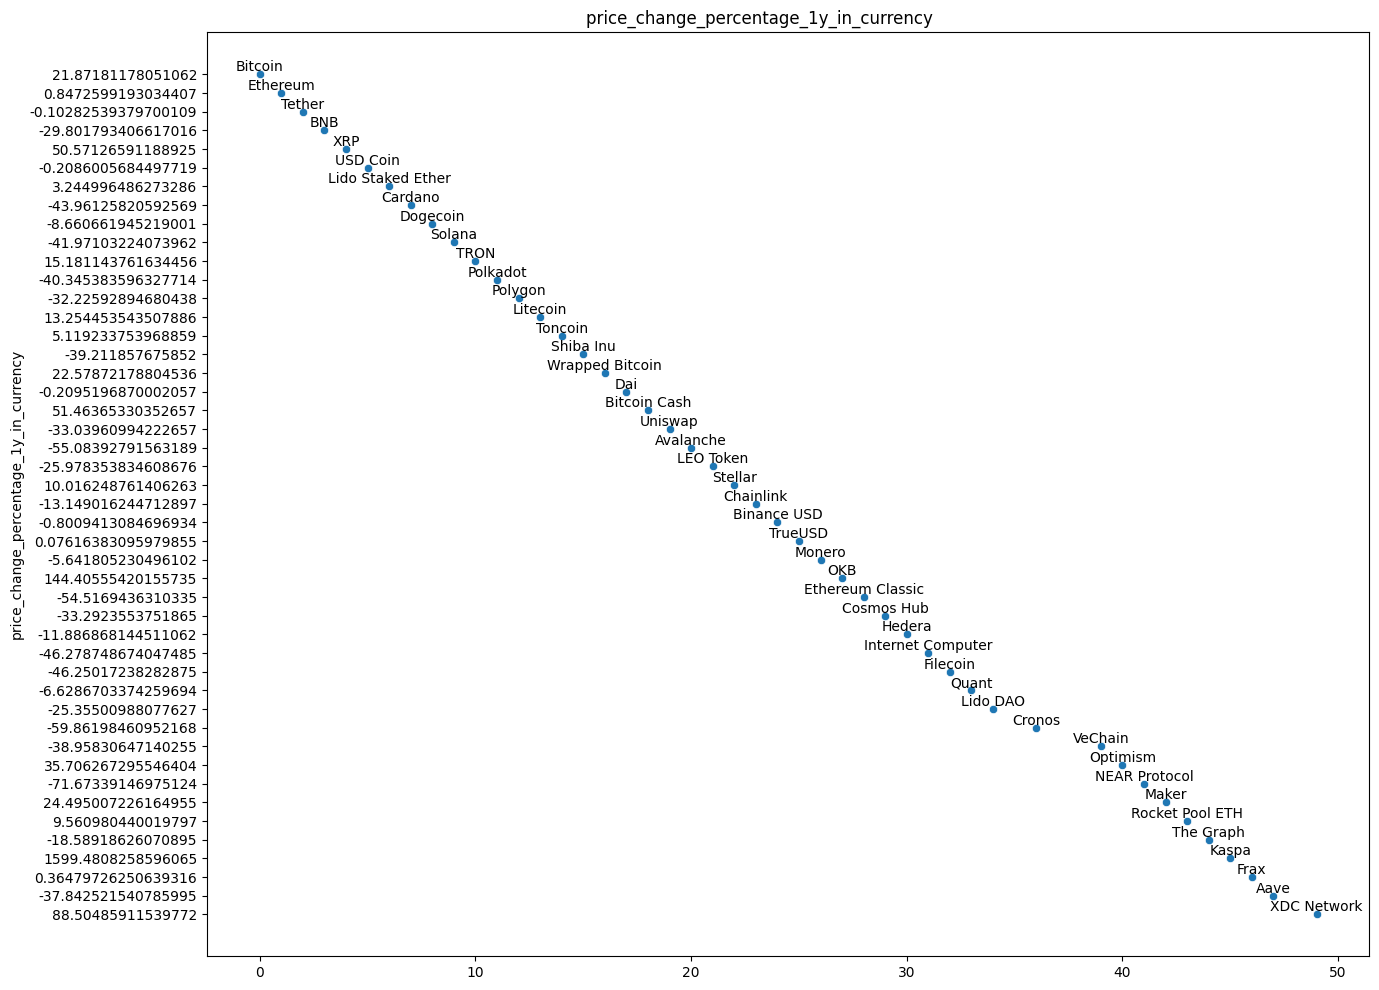

In [84]:
plt.figure(figsize=(15, 12))
sns.scatterplot(data=df['price_change_percentage_1y_in_currency'])
plt.title("price_change_percentage_1y_in_currency           ")

for index, row in df.iterrows():
    plt.text(index, row['price_change_percentage_1y_in_currency'], row['name'], ha='center', va='bottom')

plt.show()

# Análisis

Este gráfico es muy interesante porque resalta la criptomoneda "Kaspa" la cual es desconocida para mi. Voy a considerar estudiarla para ver si puedo obtener información valiosa para mi objetivo.

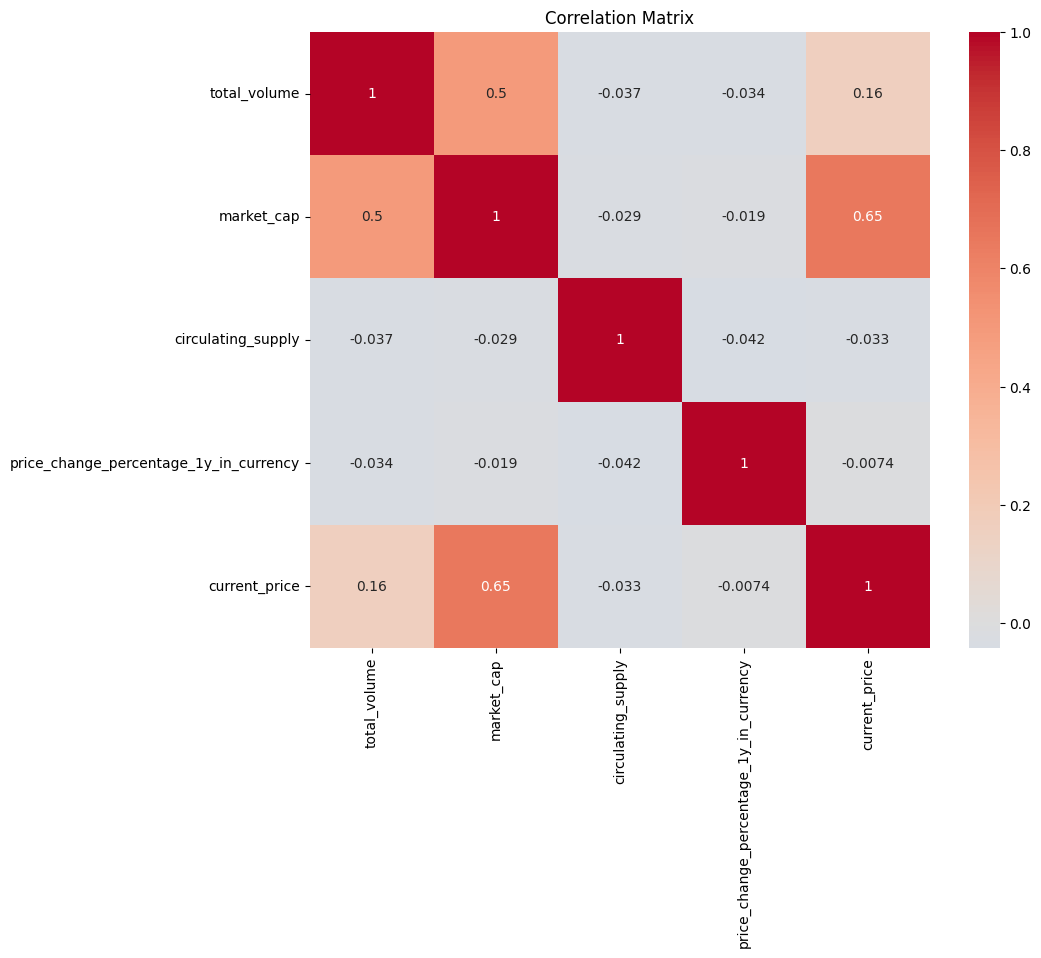

In [83]:
correlation_columns =["total_volume", "market_cap", "circulating_supply", "price_change_percentage_1y_in_currency","current_price"]

df_correlation = df[correlation_columns]

correlation_matrix = df_correlation.corr()

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()


# Análisis de la matrix de correlación

A primera vista veo que el resutlado más interesante es que mientras mayor es el marketcap de una criptomoneda, mayor es su volumen. Esto se puede dar por el hecho de que al ser mayor su valor, mayor es el volumen al cual se hacen transacciones. Mientras más popular es una criptomoneda, más adopción tiene y por ende, mayor es su volumen.
